# Ekstraksi Kata Kunci dengan Word Graph dan Analisis Sentralitas

Notebook ini melakukan ekstraksi kata kunci dari dokumen PDF menggunakan metode word graph dan berbagai pengukuran sentralitas (PageRank, Degree Centrality, Betweenness Centrality, dan Closeness Centrality).

In [81]:
%pip install pymupdf nltk networkx pandas numpy matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1. Instalasi Paket yang Diperlukan

Menginstal semua library Python yang dibutuhkan untuk:
- **pymupdf**: Ekstraksi teks dari file PDF
- **nltk**: Natural Language Processing (tokenisasi, stopwords)
- **networkx**: Pembuatan dan analisis graf
- **pandas**: Manipulasi data
- **numpy**: Operasi numerik
- **matplotlib**: Visualisasi graf

## 2. Ekstraksi Teks dari PDF

Mengekstrak seluruh teks dari file PDF dan menyimpannya ke dalam file `output.txt`. Setiap halaman dipisahkan dengan karakter form feed.

In [82]:
# Ekstraksi teks dari PDF
import pymupdf

# Buka file PDF
doc = pymupdf.open("garuda1825910.pdf")
# Buat file output untuk menyimpan teks
out = open("output.txt", "wb")

# Loop setiap halaman dalam dokumen
for page in doc:
    text = page.get_text().encode("utf8")  # Ambil teks dari halaman
    out.write(text)  # Tulis teks ke file
    out.write(bytes((12,)))  # Tulis pemisah halaman (form feed)
out.close()
print("Ekstraksi PDF selesai.")

Ekstraksi PDF selesai.


## 3. Download Resource NLTK

Mengunduh resource yang dibutuhkan untuk Natural Language Processing:
- **punkt**: Tokenizer untuk memisahkan teks menjadi kalimat
- **stopwords**: Daftar kata-kata umum yang tidak bermakna (stop words)

In [83]:
# Download resource NLTK
import nltk
nltk.download('punkt')  # Untuk tokenisasi kalimat
nltk.download('punkt_tab')  # Versi terbaru tokenizer
nltk.download('stopwords')  # Daftar stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\NITRO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\NITRO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\NITRO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 4. Tokenisasi Teks Menjadi Kalimat

Membaca file teks yang telah diekstrak, kemudian memecahnya menjadi kalimat-kalimat individual dan menyimpannya dalam file CSV.

In [84]:
# Baca dan tokenisasi teks menjadi kalimat
import pandas as pd

# Baca file teks hasil ekstraksi PDF
with open('output.txt', 'r', encoding='utf-8') as file:
    teks = file.read()

# Pisahkan teks menjadi kalimat-kalimat
sentences = nltk.sent_tokenize(teks)
# Simpan kalimat ke dalam DataFrame
df = pd.DataFrame(sentences, columns=['kalimat'])
# Simpan ke file CSV
df.to_csv('kalimat.csv', index=False, encoding='utf-8')
print(f"Total kalimat: {len(sentences)}")

Total kalimat: 211


## 5. Pembuatan Matriks Ko-okurensi dengan Unigram dan Bigram

Proses ini melakukan:
1. **Preprocessing teks**: Membersihkan teks dari angka, karakter khusus, dan stopwords
2. **Ekstraksi unigram**: Kata tunggal yang bermakna
3. **Ekstraksi bigram**: Gabungan 2 kata berurutan
4. **Matriks ko-okurensi**: Menghitung kemunculan bersama antar kata dalam jendela tertentu

In [85]:
# Membangun matriks ko-okurensi dengan unigram dan bigram
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from collections import defaultdict, Counter
import numpy as np
import re

# Baca file CSV kalimat
df = pd.read_csv("kalimat.csv")
# Gabungkan semua kalimat menjadi satu teks
text = " ".join(df.iloc[:,0].astype(str))

# Preprocessing teks: hapus angka dan karakter khusus
stop_words = set(stopwords.words('english') + stopwords.words('indonesian'))
words = word_tokenize(text.lower())  # Tokenisasi dan ubah ke huruf kecil

# Filter: hanya kata alfabetik, tanpa angka, tanpa karakter tunggal, bukan stopwords
unigrams = [word for word in words if word.isalpha() and len(word) > 1 and word not in stop_words]

# Generasi bigram (gabungan 2 kata)
bigrams_raw = list(ngrams(unigrams, 2))
bigrams_formatted = [f"{word1}_{word2}" for word1, word2 in bigrams_raw]

# Gabungkan unigram dan bigram
processed_terms = unigrams + bigrams_formatted

# Tentukan ukuran jendela untuk ko-okurensi
# Window size 5 = kata dalam jarak 5 kata akan dianggap berhubungan
window_size = 5

# Buat matriks ko-okurensi
co_occurrences = defaultdict(Counter)
for i, term in enumerate(processed_terms):
    # Untuk setiap term, cek term di sekitarnya dalam jendela
    for j in range(max(0, i - window_size), min(len(processed_terms), i + window_size + 1)):
        if i != j:
            co_occurrences[term][processed_terms[j]] += 1

# Dapatkan list term unik
unique_terms = list(set(processed_terms))
# Inisialisasi matriks ko-okurensi
co_matrix = np.zeros((len(unique_terms), len(unique_terms)), dtype=int)

# Isi matriks dengan nilai ko-okurensi
term_index = {term: idx for idx, term in enumerate(unique_terms)}
for term, neighbors in co_occurrences.items():
    for neighbor, count in neighbors.items():
        co_matrix[term_index[term]][term_index[neighbor]] = count

# Buat DataFrame dari matriks
co_matrix_df = pd.DataFrame(co_matrix, index=unique_terms, columns=unique_terms)
print("Co-occurrence matrix berhasil dibuat!")
print(f"Ukuran matriks: {co_matrix_df.shape}")
print(f"Total term unik (unigram + bigram): {len(unique_terms)}")
print("\nPreview Co-occurrence Matrix (10x10 pertama):")
co_matrix_df.head(10)

Co-occurrence matrix berhasil dibuat!
Ukuran matriks: (2209, 2209)
Total term unik (unigram + bigram): 2209

Preview Co-occurrence Matrix (10x10 pertama):


mencetak  tahap_pembuatan  menyediakan_desain  \
mencetak                   0                0                   0   
tahap_pembuatan            0                0                   0   
menyediakan_desain         0                0                   0   
booklet_bangunan           0                0                   0   
pembuatan_akun             0                0                   0   
pembahasan_ketiga          0                0                   0   
energi                     0                0                   0   
pelepasan                  0                0                   0   
salah_media                0                0                   0   
printer_mencetak           0                0                   0   

                    booklet_bangunan  pembuatan_akun  pembahasan_ketiga  \
mencetak                           0               0                  0   
tahap_pembuatan                    0               0                  0   
menyediakan_desain                 0               0                  0   
booklet_bangunan                   0               0                  0   
pembuatan_akun                     0               2                  0   
pembahasan_ketiga                  0               0                  0   
energi                             0               0                  0   
pelepasan                          0               0                  0   
salah_media                        0               0                  0   
printer_mencetak                   0               0                  0   

                    energi  pelepasan  salah_media  printer_mencetak  ...  \
mencetak                 0          0            0                 0  ...   
tahap_pembuatan          0          0            0                 0  ...   
menyediakan_desain       0          0            0                 0  ...   
booklet_bangunan         0          0            0                 0  ...   
pembuatan_akun           0          0            0                 0  ...   
pembahasan_ketiga        0          0            0                 0  ...   
energi                   0          1            0                 0  ...   
pelepasan                1          0            0                 0  ...   
salah_media              0          0            0                 0  ...   
printer_mencetak         0          0            0                 0  ...   

                    sesuai_format  proses_pencetakan  ajaran_dipetik  jalur  \
mencetak                        0                  0               0      0   
tahap_pembuatan                 0                  1               0      0   
menyediakan_desain              0                  0               0      0   
booklet_bangunan                0                  0               0      0   
pembuatan_akun                  0                  0               0      0   
pembahasan_ketiga               0                  0               0      0   
energi                          0                  0               0      0   
pelepasan                       0                  0               0      0   
salah_media                     0                  0               0      0   
printer_mencetak                0                  0               0      0   

                    penggunaan_aplikasi  http_supriyono  menjadikannya  maret  \
mencetak                              0               0              0      0   
tahap_pembuatan                       0               0              0      0   
menyediakan_desain                    0               0              0      0   
booklet_bangunan                      0               0              0      0   
pembuatan_akun                        0               0              0      0   
pembahasan_ketiga                     0               0              0      0   
energi                                0               0              0      0   
pelepasan                             0               0             

In [87]:
# Buat graf dari matriks ko-okurensi
import networkx as nx

# Konversi matriks adjacency menjadi graf NetworkX
G_raw = nx.from_pandas_adjacency(co_matrix_df)
print(f"Graf awal dibuat dengan {len(G_raw.nodes)} node dan {len(G_raw.edges)} edge.")

# FILTERING 1: Hapus node dengan degree < 2 (node yang terisolasi atau terhubung minimal)
print("\n🔄 Filtering node dengan koneksi rendah...")
G_filtered = G_raw.copy()
isolated_nodes = [node for node, degree in dict(G_filtered.degree()).items() if degree < 2]
G_filtered.remove_nodes_from(isolated_nodes)
print(f"✅ Dihapus {len(isolated_nodes)} node dengan degree < 2")
print(f"   Sisa: {len(G_filtered.nodes)} node dan {len(G_filtered.edges)} edge")

# FILTERING 2: Ambil komponen terhubung terbesar (main cluster)
print("\n🔄 Mengambil komponen terhubung terbesar...")
if len(G_filtered.nodes) > 0:
    connected_components = list(nx.connected_components(G_filtered))
    largest_component = max(connected_components, key=len)
    G = G_filtered.subgraph(largest_component).copy()
    print(f"✅ Komponen terbesar memiliki {len(G.nodes)} node dan {len(G.edges)} edge")
    print(f"   Total komponen terpisah: {len(connected_components)}")
else:
    G = G_filtered

print(f"\n📊 GRAF FINAL: {len(G.nodes)} node dan {len(G.edges)} edge (semuanya terhubung!)")

Graf awal dibuat dengan 2209 node dan 15903 edge.

🔄 Filtering node dengan koneksi rendah...
✅ Dihapus 0 node dengan degree < 2
   Sisa: 2209 node dan 15903 edge

🔄 Mengambil komponen terhubung terbesar...
✅ Komponen terbesar memiliki 2209 node dan 15903 edge
   Total komponen terpisah: 1

📊 GRAF FINAL: 2209 node dan 15903 edge (semuanya terhubung!)


🔄 Membuat visualisasi untuk 2209 node yang terhubung... (ini mungkin memakan waktu 2-3 menit)
📊 Graf ini sudah difilter: hanya node dengan degree ≥ 2 dan komponen terbesar
🔄 Menghitung layout graph (Kamada-Kawai)...
🔄 Menggambar edges...
🔄 Menggambar nodes...
🔄 Menggambar labels untuk node penting...


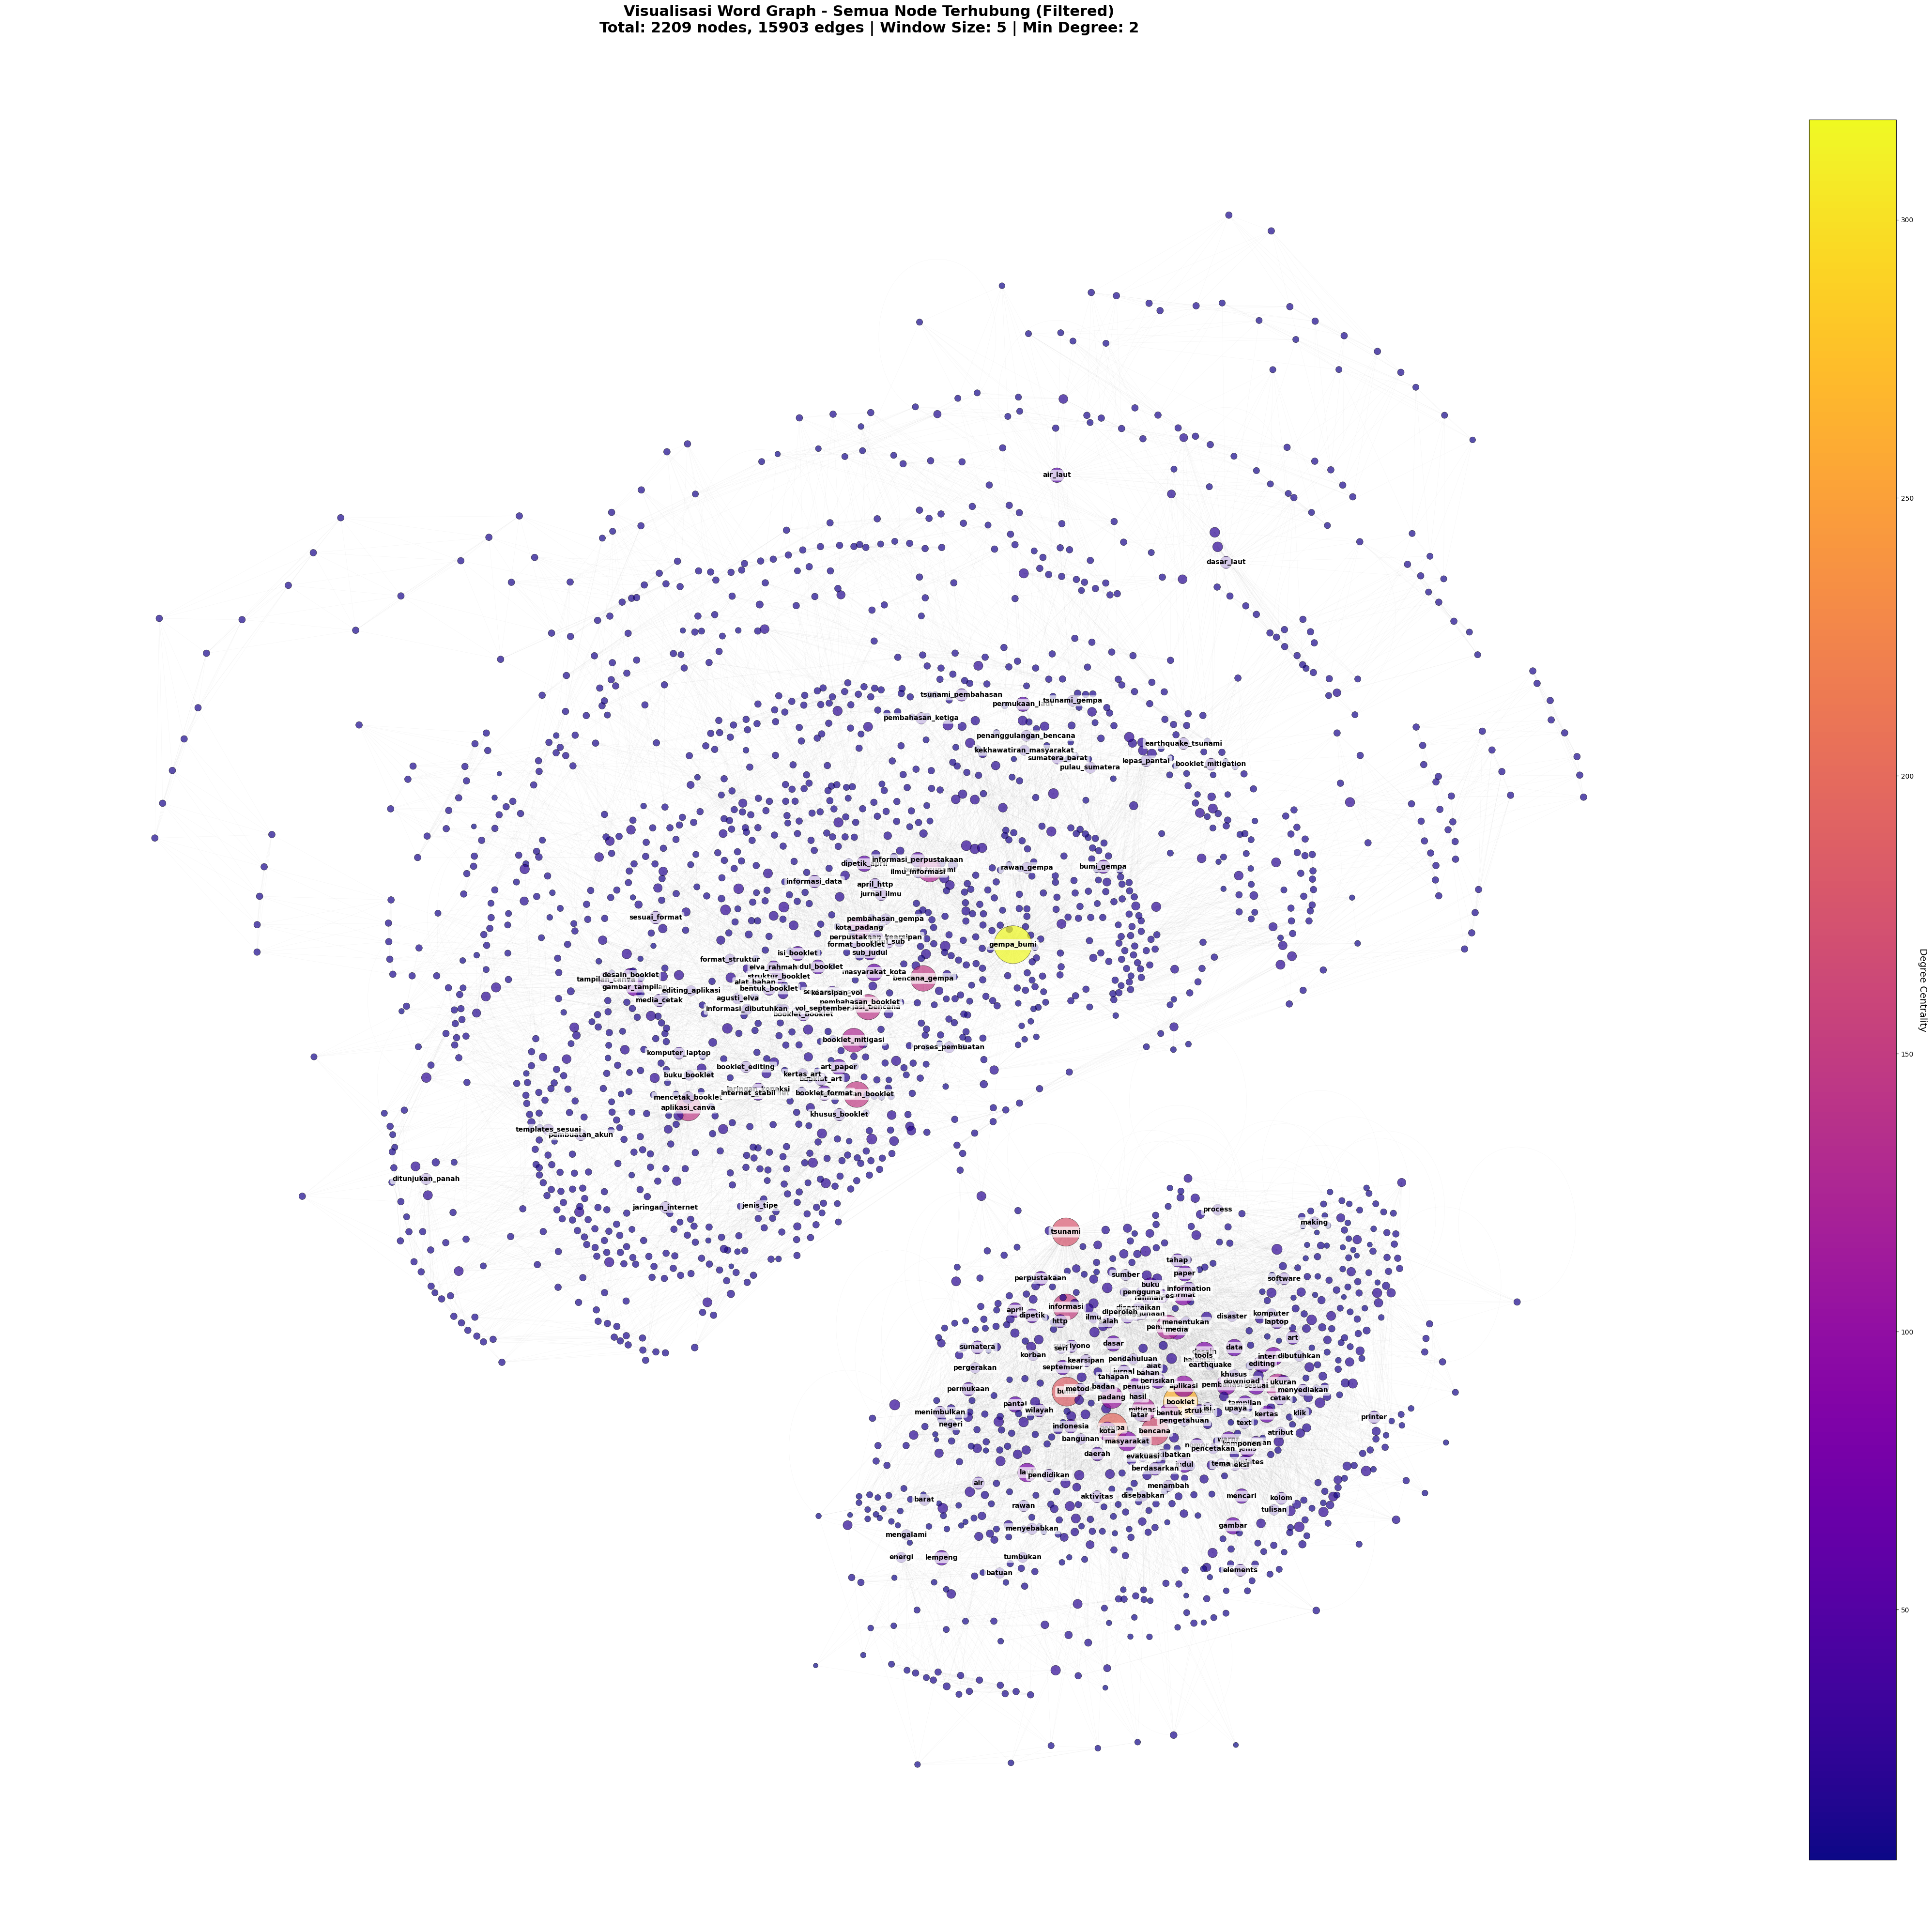


✅ Visualisasi menampilkan 2209 node dan 15903 edge
📊 Labels ditampilkan untuk 200 node dengan degree tertinggi


In [88]:
# Visualisasi Word Graph (Semua Node - Setelah Filtering)
import matplotlib.pyplot as plt

print(f"🔄 Membuat visualisasi untuk {len(G.nodes)} node yang terhubung... (ini mungkin memakan waktu 2-3 menit)")
print(f"📊 Graf ini sudah difilter: hanya node dengan degree ≥ 2 dan komponen terbesar")

# Setup figure dengan ukuran besar
plt.figure(figsize=(40, 40))

# Hitung degree untuk setiap node
degree_dict = dict(G.degree())

# Layout graph menggunakan spring layout dengan parameter yang dioptimalkan
# Menggunakan k yang lebih besar untuk memberikan jarak antar node
try:
    print("🔄 Menghitung layout graph (Kamada-Kawai)...")
    pos = nx.kamada_kawai_layout(G)
except:
    print("🔄 Menggunakan spring layout sebagai fallback...")
    pos = nx.spring_layout(G, k=1.5, iterations=30, seed=42)

# Ukuran node berdasarkan degree (lebih proporsional)
node_sizes = [max(30, degree_dict[node] * 10) for node in G.nodes()]

# Warna node berdasarkan degree
node_colors = [degree_dict[node] for node in G.nodes()]

# Gambar edges terlebih dahulu (di layer paling bawah)
print("🔄 Menggambar edges...")
nx.draw_networkx_edges(G, pos, 
                       alpha=0.1,
                       width=0.3,
                       edge_color='gray')

# Gambar nodes
print("🔄 Menggambar nodes...")
nx.draw_networkx_nodes(G, pos, 
                       node_size=node_sizes,
                       node_color=node_colors,
                       cmap=plt.cm.plasma,
                       alpha=0.7,
                       edgecolors='black',
                       linewidths=0.5)

# Tambahkan colorbar untuk menunjukkan skala degree
sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, 
                           norm=plt.Normalize(vmin=min(node_colors), 
                                            vmax=max(node_colors)))
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca(), fraction=0.046, pad=0.04)
cbar.set_label('Degree Centrality', rotation=270, labelpad=20, fontsize=14)

# Gambar labels hanya untuk node penting (degree tinggi)
# Untuk menjaga kejelasan, tampilkan label untuk top 200 node
print("🔄 Menggambar labels untuk node penting...")
top_nodes = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:200]
top_node_dict = {node: node for node, _ in top_nodes}

# Labels dengan ukuran font yang disesuaikan berdasarkan degree
for node, degree in top_nodes:
    if degree > 15:
        font_size = 10
    elif degree > 10:
        font_size = 8
    elif degree > 5:
        font_size = 6
    else:
        font_size = 5
    
    x, y = pos[node]
    plt.text(x, y, node, 
            fontsize=font_size,
            ha='center', 
            va='center',
            bbox=dict(boxstyle='round,pad=0.3', 
                     facecolor='white', 
                     edgecolor='none',
                     alpha=0.7),
            fontweight='bold')

plt.title("Visualisasi Word Graph - Semua Node Terhubung (Filtered)\n" + 
          f"Total: {len(G.nodes())} nodes, {len(G.edges())} edges | Window Size: 5 | Min Degree: 2", 
          fontsize=22, fontweight='bold', pad=30)
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"\n✅ Visualisasi menampilkan {len(G.nodes())} node dan {len(G.edges())} edge")
print(f"📊 Labels ditampilkan untuk 200 node dengan degree tertinggi")

## 6. Pembuatan Graf dari Matriks Ko-okurensi

Mengkonversi matriks ko-okurensi menjadi graf NetworkX di mana:
- **Node**: Kata-kata (unigram dan bigram)
- **Edge**: Hubungan ko-okurensi antar kata
- **Bobot**: Frekuensi kemunculan bersama

## 7. Seleksi 20 Kata Kunci Teratas

Menghitung Degree Centrality untuk semua node dan memilih 20 kata dengan nilai tertinggi. Degree Centrality mengukur seberapa banyak koneksi yang dimiliki sebuah kata dengan kata lain.

In [ ]:
# Hitung degree centrality dan pilih 20 node teratas
degree_centrality = nx.degree_centrality(G)
# Urutkan node berdasarkan degree centrality (tertinggi ke terendah)
top_20_nodes = sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)[:20]

print("\n20 Kata Teratas Berdasarkan Degree Centrality:")
for i, (node, degree) in enumerate(top_20_nodes, 1):
    print(f"{i}. {node}: {degree:.4f}")


20 Kata Teratas Berdasarkan Degree Centrality:
1. booklet: 0.0720
2. gempa_bumi: 0.0639
3. bumi: 0.0444
4. gempa: 0.0403
5. tsunami: 0.0385
6. informasi: 0.0371
7. bencana: 0.0340
8. aplikasi_canva: 0.0303
9. canva: 0.0303
10. pembuatan_booklet: 0.0299
11. pembuatan: 0.0285
12. aplikasi: 0.0240
13. laut: 0.0226
14. bumi_tsunami: 0.0222
15. desain: 0.0217
16. bentuk: 0.0217
17. masyarakat: 0.0213
18. pembahasan: 0.0208
19. padang: 0.0204
20. kota_padang: 0.0186


In [ ]:
# Buat subgraf dengan 20 node teratas
top_node_names = [node for node, _ in top_20_nodes]
# Ekstrak subgraf yang hanya berisi 20 node teratas
subgraph = G.subgraph(top_node_names)
print(f"\nSubgraf dibuat dengan {len(subgraph.nodes)} node dan {len(subgraph.edges)} edge.")


Subgraf dibuat dengan 20 node dan 71 edge.


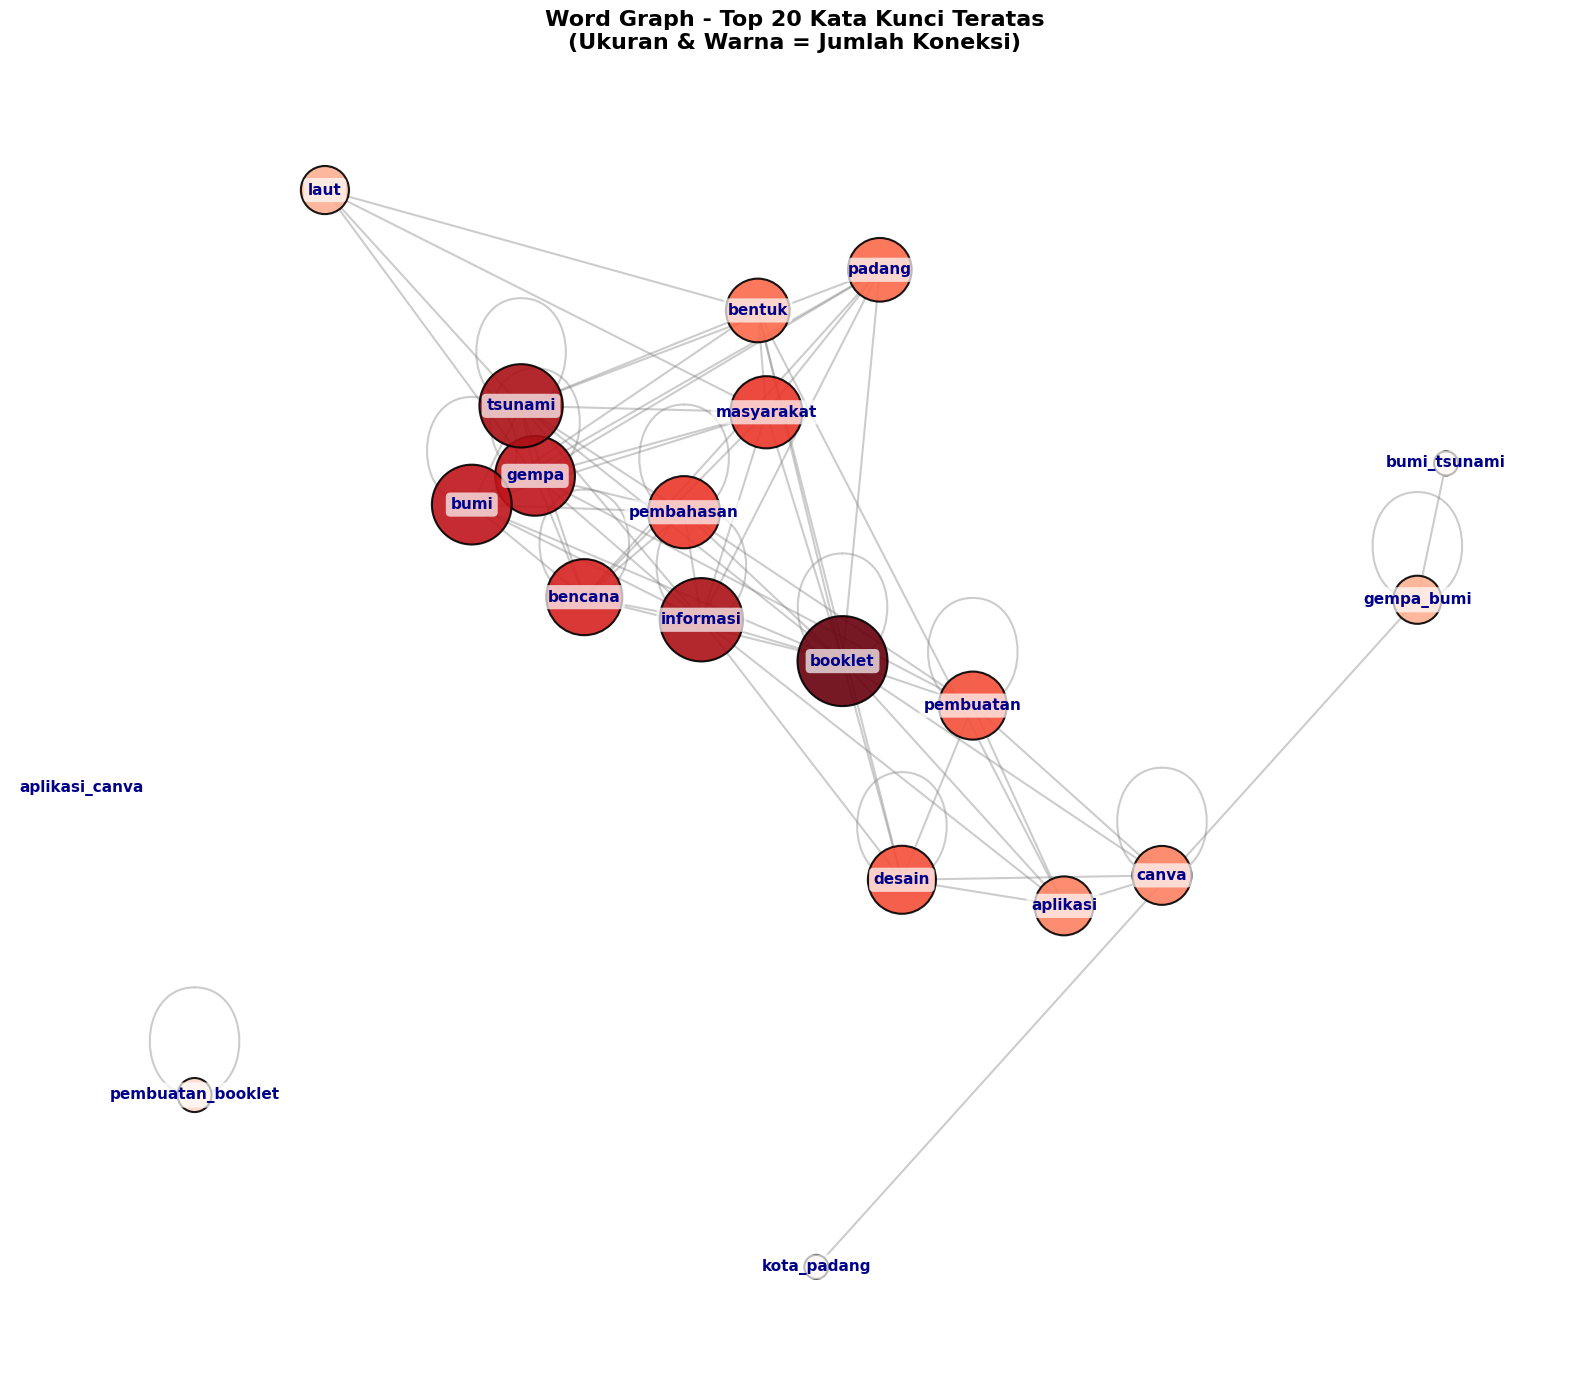


✅ Visualisasi menampilkan 20 kata kunci dengan 71 hubungan


In [ ]:
# Visualisasi Subgraph - Top 20 Kata Kunci
import matplotlib.pyplot as plt

# Setup figure
plt.figure(figsize=(16, 14))

# Layout graph menggunakan spring layout untuk posisi yang optimal
pos = nx.spring_layout(subgraph, k=1.5, iterations=50, seed=42)

# Hitung degree untuk setiap node di subgraph
subgraph_degrees = dict(subgraph.degree())

# Ukuran node berdasarkan degree
node_sizes = [subgraph_degrees[node] * 300 for node in subgraph.nodes()]

# Warna node berdasarkan degree (gradient)
node_colors = [subgraph_degrees[node] for node in subgraph.nodes()]

# Gambar node dengan gradient warna
nx.draw_networkx_nodes(subgraph, pos, 
                       node_size=node_sizes,
                       node_color=node_colors,
                       cmap=plt.cm.Reds,
                       alpha=0.9,
                       edgecolors='black',
                       linewidths=1.5)

# Gambar edges dengan transparansi
nx.draw_networkx_edges(subgraph, pos, 
                       alpha=0.4,
                       width=1.5,
                       edge_color='gray')

# Gambar labels (kata-kata) dengan background putih untuk readability
nx.draw_networkx_labels(subgraph, pos, 
                        font_size=11,
                        font_weight='bold',
                        font_color='darkblue',
                        bbox=dict(boxstyle='round,pad=0.3', 
                                 facecolor='white', 
                                 edgecolor='none',
                                 alpha=0.7))

plt.title("Word Graph - Top 20 Kata Kunci Teratas\n(Ukuran & Warna = Jumlah Koneksi)", 
          fontsize=16, fontweight='bold', pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"\n✅ Visualisasi menampilkan {len(subgraph.nodes())} kata kunci dengan {len(subgraph.edges())} hubungan")

## 8. Pembuatan Subgraf

Membuat subgraf yang hanya berisi 20 node teratas beserta koneksi antar mereka untuk analisis yang lebih fokus.

## 9. Perhitungan Semua Ukuran Sentralitas

Menghitung 4 ukuran sentralitas yang berbeda untuk mengidentifikasi kata kunci penting:

1. **PageRank**: Mengukur kepentingan kata berdasarkan struktur jaringan (kata yang terhubung ke kata penting lain)
2. **Degree Centrality**: Mengukur jumlah koneksi langsung yang dimiliki kata
3. **Betweenness Centrality**: Mengukur seberapa sering kata menjadi jembatan antara kata lain
4. **Closeness Centrality**: Mengukur kedekatan rata-rata kata ke semua kata lain dalam jaringan

In [ ]:
# Hitung semua ukuran sentralitas
print("\nMenghitung ukuran sentralitas...")

# 1. PageRank - Mengukur kepentingan node berdasarkan struktur link
pagerank_values = nx.pagerank(subgraph)
pagerank_df = pd.DataFrame(list(pagerank_values.items()), columns=['Kata', 'PageRank'])
pagerank_df = pagerank_df.sort_values(by='PageRank', ascending=False)

# 2. Degree Centrality - Mengukur jumlah koneksi langsung
degree_centrality_sub = nx.degree_centrality(subgraph)
degree_df = pd.DataFrame(list(degree_centrality_sub.items()), columns=['Kata', 'Degree_Centrality'])
degree_df = degree_df.sort_values(by='Degree_Centrality', ascending=False)

# 3. Betweenness Centrality - Mengukur seberapa sering node menjadi jembatan
betweenness_centrality = nx.betweenness_centrality(subgraph)
betweenness_df = pd.DataFrame(list(betweenness_centrality.items()), columns=['Kata', 'Betweenness_Centrality'])
betweenness_df = betweenness_df.sort_values(by='Betweenness_Centrality', ascending=False)

# 4. Closeness Centrality - Mengukur kedekatan node ke semua node lain
closeness_centrality = nx.closeness_centrality(subgraph)
closeness_df = pd.DataFrame(list(closeness_centrality.items()), columns=['Kata', 'Closeness_Centrality'])
closeness_df = closeness_df.sort_values(by='Closeness_Centrality', ascending=False)

print("Semua ukuran sentralitas berhasil dihitung.")


Menghitung ukuran sentralitas...
Semua ukuran sentralitas berhasil dihitung.


In [ ]:
# Tampilkan hasil PageRank
print("\n" + "="*60)
print("PAGERANK CENTRALITY (Sentralitas PageRank)")
print("="*60)
print(pagerank_df.to_string(index=False))


PAGERANK CENTRALITY (Sentralitas PageRank)
             Kata  PageRank
            gempa  0.104023
          booklet  0.101968
             bumi  0.101670
       gempa_bumi  0.080192
          tsunami  0.074220
          bencana  0.069666
     bumi_tsunami  0.066791
pembuatan_booklet  0.052219
            canva  0.046543
        pembuatan  0.045388
        informasi  0.042920
       masyarakat  0.040350
         aplikasi  0.039505
       pembahasan  0.033882
           desain  0.026552
           padang  0.024347
           bentuk  0.017830
             laut  0.014426
      kota_padang  0.009675
   aplikasi_canva  0.007833


## 10. Hasil dan Visualisasi PageRank

PageRank menentukan kata kunci paling penting berdasarkan struktur jaringan. Kata dengan PageRank tinggi adalah kata yang terhubung dengan banyak kata penting lainnya.

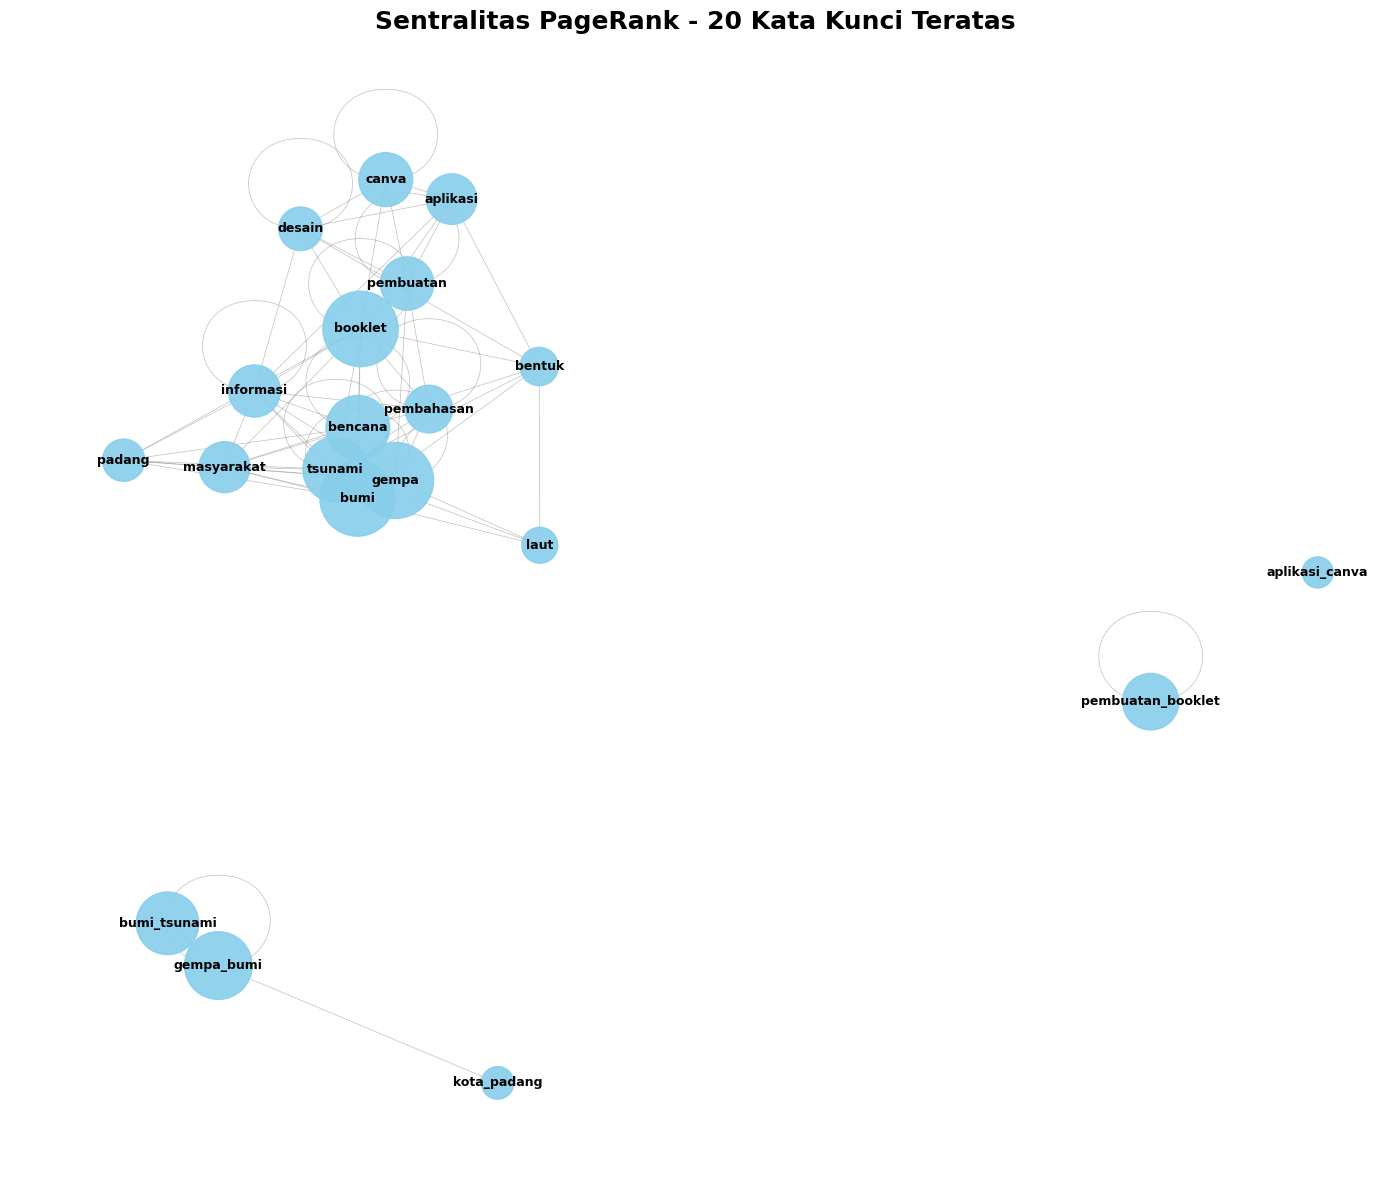

In [ ]:
# Visualisasi PageRank
import matplotlib.pyplot as plt

# Buat figure dengan ukuran besar
plt.figure(figsize=(14, 12))
# Tentukan posisi node menggunakan spring layout
pos = nx.spring_layout(subgraph, k=0.8, iterations=50)

# Normalisasi ukuran node berdasarkan nilai PageRank
max_pr = max(pagerank_values.values())
min_pr = min(pagerank_values.values())
node_sizes = [500 + (v - min_pr) / (max_pr - min_pr) * 2500 if max_pr != min_pr else 1000 for v in pagerank_values.values()]

# Gambar node, edge, dan label
nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes, node_color='skyblue', alpha=0.9)
nx.draw_networkx_edges(subgraph, pos, width=0.5, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(subgraph, pos, font_size=9, font_weight='bold')

plt.title("Sentralitas PageRank - 20 Kata Kunci Teratas", fontsize=18, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Tampilkan hasil Degree Centrality
print("\n" + "="*60)
print("DEGREE CENTRALITY (Sentralitas Derajat)")
print("="*60)
print(degree_df.to_string(index=False))


DEGREE CENTRALITY (Sentralitas Derajat)
             Kata  Degree_Centrality
          booklet           0.736842
          tsunami           0.631579
        informasi           0.631579
            gempa           0.578947
             bumi           0.578947
          bencana           0.526316
       pembahasan           0.473684
       masyarakat           0.473684
        pembuatan           0.421053
           desain           0.421053
           padang           0.368421
           bentuk           0.368421
            canva           0.315789
         aplikasi           0.315789
       gempa_bumi           0.210526
             laut           0.210526
pembuatan_booklet           0.105263
      kota_padang           0.052632
     bumi_tsunami           0.052632
   aplikasi_canva           0.000000


## 11. Hasil dan Visualisasi Degree Centrality

Degree Centrality mengidentifikasi kata yang memiliki koneksi terbanyak dengan kata lain. Semakin tinggi nilai degree centrality, semakin banyak kata yang berhubungan dengannya.

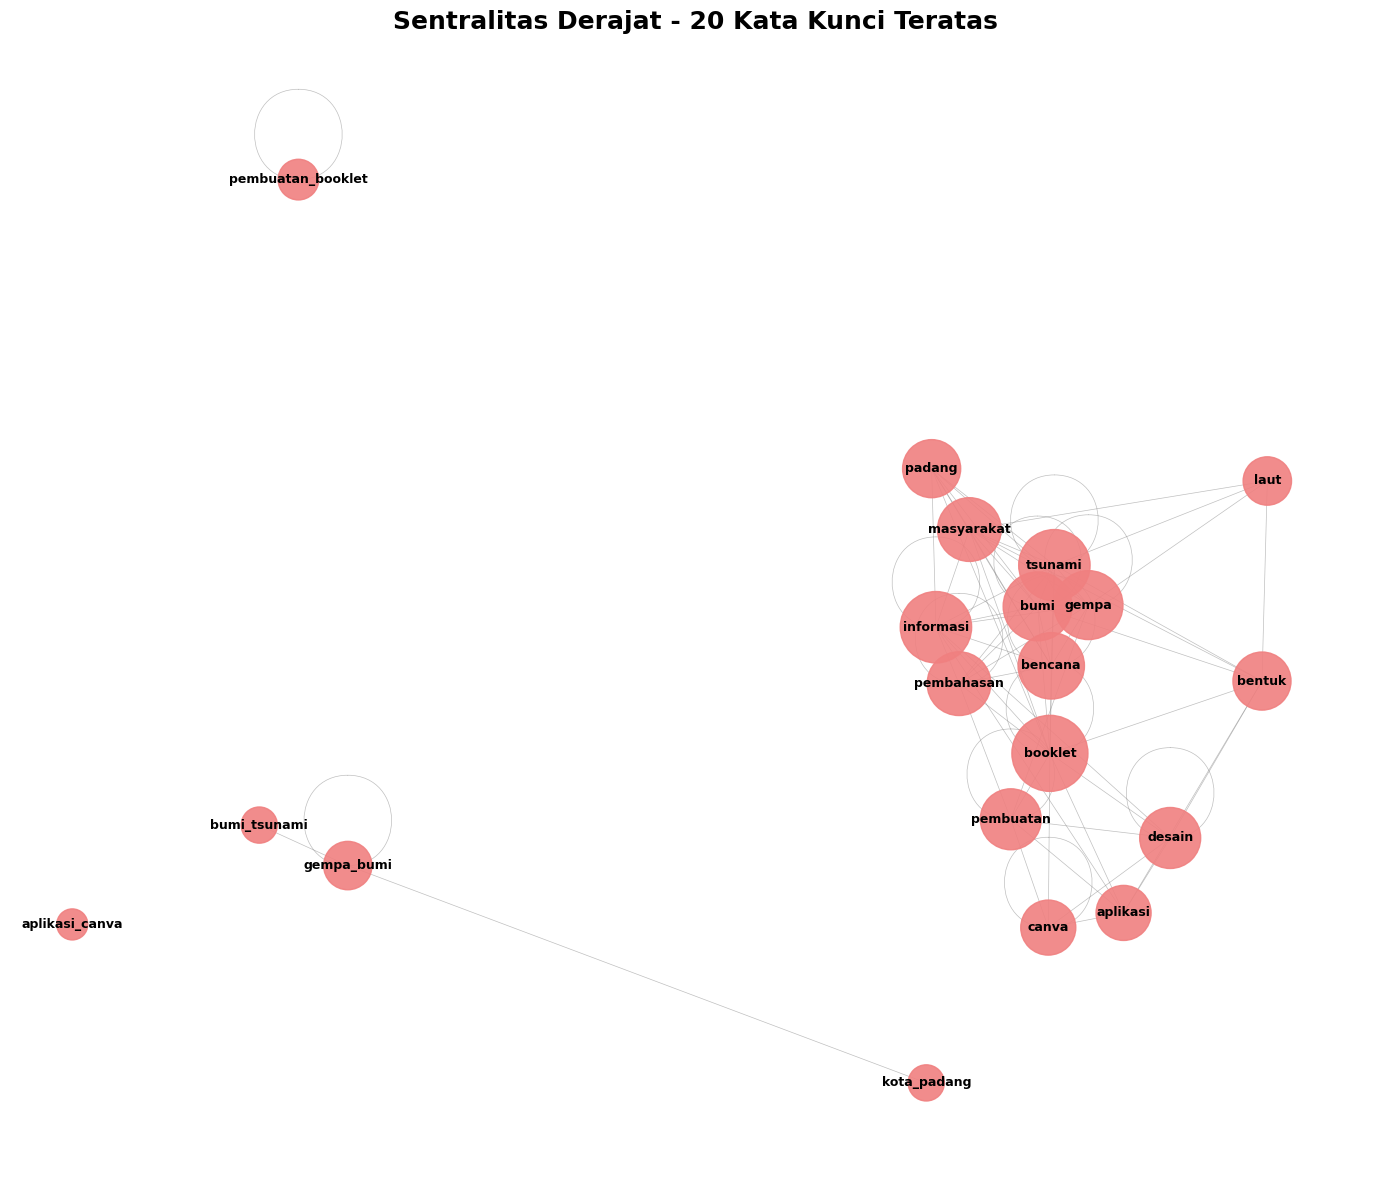

In [ ]:
# Visualisasi Degree Centrality
plt.figure(figsize=(14, 12))
pos = nx.spring_layout(subgraph, k=0.8, iterations=50)

# Normalisasi ukuran node berdasarkan degree centrality
max_deg = max(degree_centrality_sub.values())
min_deg = min(degree_centrality_sub.values())
node_sizes = [500 + (v - min_deg) / (max_deg - min_deg) * 2500 if max_deg != min_deg else 1000 for v in degree_centrality_sub.values()]

nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes, node_color='lightcoral', alpha=0.9)
nx.draw_networkx_edges(subgraph, pos, width=0.5, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(subgraph, pos, font_size=9, font_weight='bold')

plt.title("Sentralitas Derajat - 20 Kata Kunci Teratas", fontsize=18, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Tampilkan hasil Betweenness Centrality
print("\n" + "="*60)
print("BETWEENNESS CENTRALITY (Sentralitas Keantaraan)")
print("="*60)
print(betweenness_df.to_string(index=False))


BETWEENNESS CENTRALITY (Sentralitas Keantaraan)
             Kata  Betweenness_Centrality
          booklet                0.088889
        informasi                0.035819
            gempa                0.031871
           bentuk                0.029727
          tsunami                0.023148
        pembuatan                0.020224
       masyarakat                0.016326
             bumi                0.009990
         aplikasi                0.008967
           desain                0.008967
       pembahasan                0.007749
       gempa_bumi                0.005848
          bencana                0.002680
             laut                0.001462
           padang                0.000731
pembuatan_booklet                0.000000
      kota_padang                0.000000
            canva                0.000000
   aplikasi_canva                0.000000
     bumi_tsunami                0.000000


## 12. Hasil dan Visualisasi Betweenness Centrality

Betweenness Centrality mengidentifikasi kata yang berperan sebagai jembatan dalam jaringan. Kata dengan nilai tinggi menghubungkan kelompok kata yang berbeda.

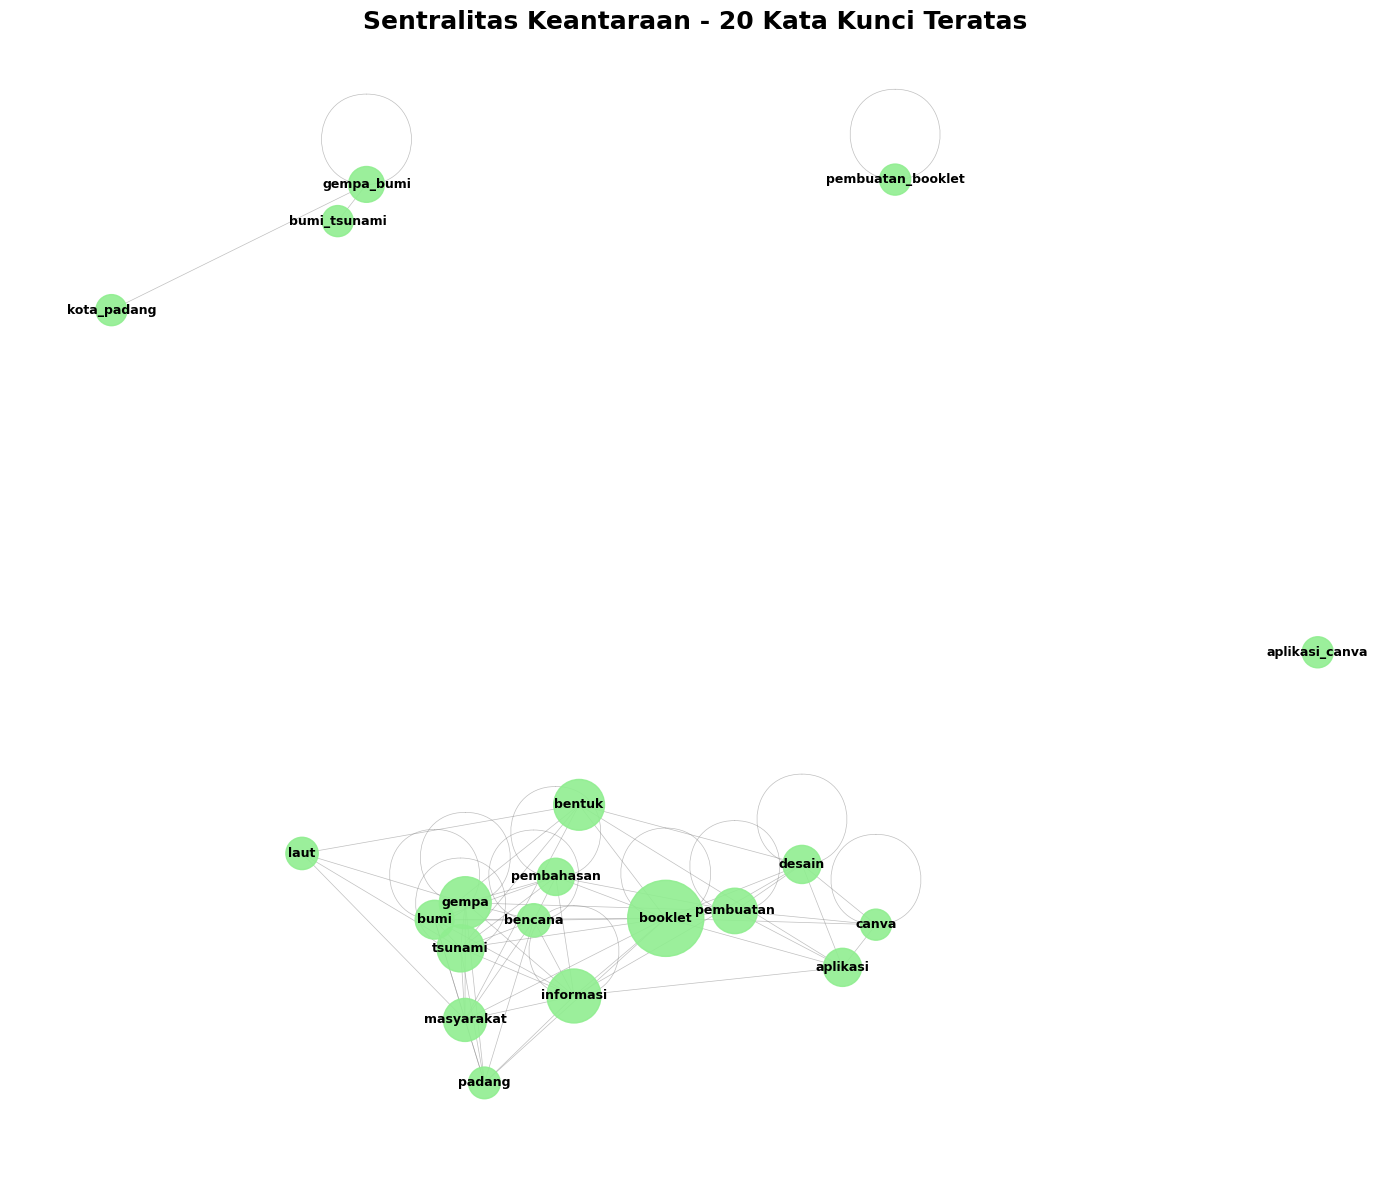

In [ ]:
# Visualisasi Betweenness Centrality
plt.figure(figsize=(14, 12))
pos = nx.spring_layout(subgraph, k=0.8, iterations=50)

# Normalisasi ukuran node berdasarkan betweenness centrality
max_btw = max(betweenness_centrality.values())
min_btw = min(betweenness_centrality.values())
node_sizes = [500 + (v - min_btw) / (max_btw - min_btw) * 2500 if max_btw != min_btw else 1000 for v in betweenness_centrality.values()]

nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes, node_color='lightgreen', alpha=0.9)
nx.draw_networkx_edges(subgraph, pos, width=0.5, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(subgraph, pos, font_size=9, font_weight='bold')

plt.title("Sentralitas Keantaraan - 20 Kata Kunci Teratas", fontsize=18, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Tampilkan hasil Closeness Centrality
print("\n" + "="*60)
print("CLOSENESS CENTRALITY (Sentralitas Kedekatan)")
print("="*60)
print(closeness_df.to_string(index=False))


CLOSENESS CENTRALITY (Sentralitas Kedekatan)
             Kata  Closeness_Centrality
          booklet              0.644737
          tsunami              0.573099
        informasi              0.573099
             bumi              0.542936
       masyarakat              0.542936
            gempa              0.542936
          bencana              0.515789
           padang              0.491228
           bentuk              0.491228
       pembahasan              0.491228
        pembuatan              0.468900
         aplikasi              0.468900
           desain              0.468900
             laut              0.412632
            canva              0.412632
       gempa_bumi              0.105263
      kota_padang              0.070175
     bumi_tsunami              0.070175
pembuatan_booklet              0.000000
   aplikasi_canva              0.000000


## 13. Hasil dan Visualisasi Closeness Centrality

Closeness Centrality mengukur seberapa dekat sebuah kata dengan semua kata lainnya. Kata dengan nilai tinggi dapat dengan cepat terhubung ke kata lain dalam jaringan.

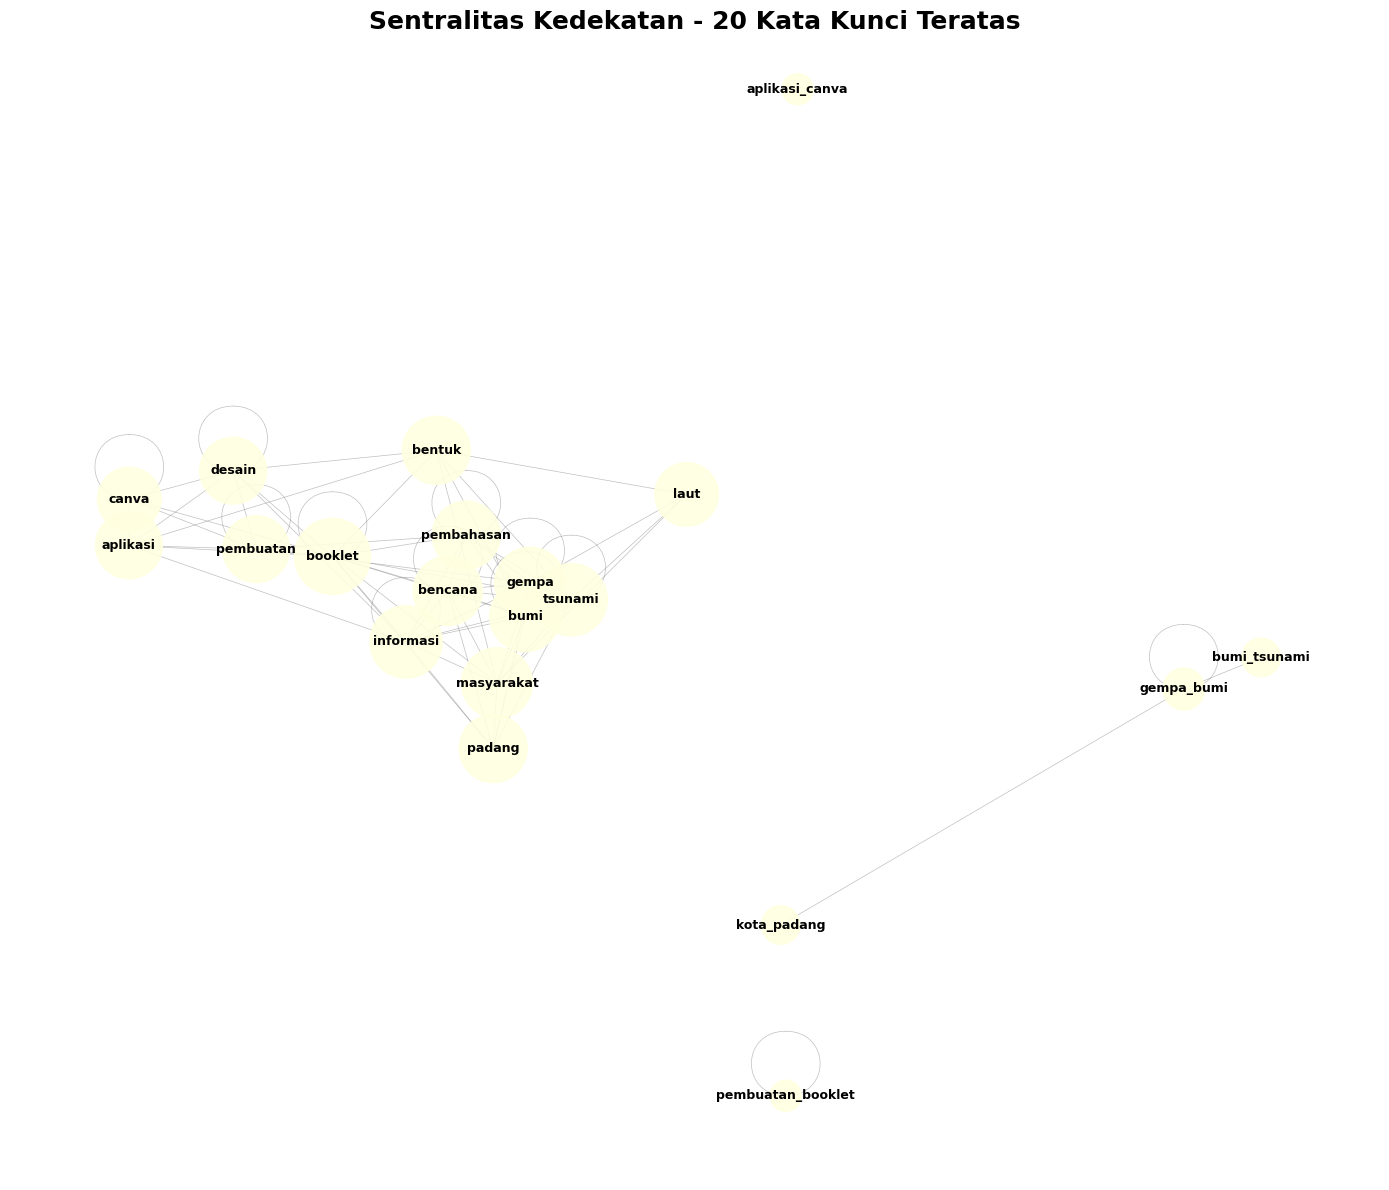

In [ ]:
# Visualisasi Closeness Centrality
plt.figure(figsize=(14, 12))
pos = nx.spring_layout(subgraph, k=0.8, iterations=50)

# Normalisasi ukuran node berdasarkan closeness centrality
max_clo = max(closeness_centrality.values())
min_clo = min(closeness_centrality.values())
node_sizes = [500 + (v - min_clo) / (max_clo - min_clo) * 2500 if max_clo != min_clo else 1000 for v in closeness_centrality.values()]

nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes, node_color='lightyellow', alpha=0.9)
nx.draw_networkx_edges(subgraph, pos, width=0.5, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(subgraph, pos, font_size=9, font_weight='bold')

plt.title("Sentralitas Kedekatan - 20 Kata Kunci Teratas", fontsize=18, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Ringkasan: Semua Ukuran Sentralitas Digabungkan
summary_df = pd.DataFrame({
    'Kata': pagerank_df['Kata'],
    'PageRank': pagerank_df['PageRank'].values,
    'Degree': [degree_centrality_sub[node] for node in pagerank_df['Kata']],
    'Betweenness': [betweenness_centrality[node] for node in pagerank_df['Kata']],
    'Closeness': [closeness_centrality[node] for node in pagerank_df['Kata']]
})

print("\n" + "="*90)
print("RINGKASAN: SEMUA UKURAN SENTRALITAS UNTUK 20 KATA KUNCI TERATAS")
print("="*90)
print(summary_df.to_string(index=False))

# Simpan hasil ke file CSV
summary_df.to_csv('hasil_ekstraksi_kata_kunci.csv', index=False)
print("\nHasil disimpan ke 'hasil_ekstraksi_kata_kunci.csv'")


RINGKASAN: SEMUA UKURAN SENTRALITAS UNTUK 20 KATA KUNCI TERATAS
             Kata  PageRank   Degree  Betweenness  Closeness
            gempa  0.104023 0.578947     0.031871   0.542936
          booklet  0.101968 0.736842     0.088889   0.644737
             bumi  0.101670 0.578947     0.009990   0.542936
       gempa_bumi  0.080192 0.210526     0.005848   0.105263
          tsunami  0.074220 0.631579     0.023148   0.573099
          bencana  0.069666 0.526316     0.002680   0.515789
     bumi_tsunami  0.066791 0.052632     0.000000   0.070175
pembuatan_booklet  0.052219 0.105263     0.000000   0.000000
            canva  0.046543 0.315789     0.000000   0.412632
        pembuatan  0.045388 0.421053     0.020224   0.468900
        informasi  0.042920 0.631579     0.035819   0.573099
       masyarakat  0.040350 0.473684     0.016326   0.542936
         aplikasi  0.039505 0.315789     0.008967   0.468900
       pembahasan  0.033882 0.473684     0.007749   0.491228
           desain  0

## 14. Ringkasan Hasil

Menampilkan tabel ringkasan yang menggabungkan semua ukuran sentralitas untuk 20 kata kunci teratas. Tabel ini memudahkan perbandingan antar metrik dan menyimpan hasilnya ke file CSV.